## Imports

In [2]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks
import matplotlib.pyplot as plt

#check PyTorch version
torch.__version__

'2.0.1'

## 01. PyTorch Workflow Fundamentals

Let's explore an example PyTorch end-toend workflow

In [3]:
what_we_re_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}
what_we_re_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

### 1. Data (Preparing and Loading)

Machine Learning is a game of **two parts**:
1. **Get data** into a **numerical representation**.
2. **Build a model** to **learn patterns** from that **numerical representation**.
   
![](imgs/machine-learning-2-parts.png){ width=50%}

In [ ]:
# create known parameters
weight = 0.7
bias = 0.3

# create new values
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

In [5]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

#### Splitting a data

- Training, validation, and test set
- we usually do 60-80% split for training data
- 10-20% for validation set
- 10-20% for test set

In [6]:
# create train-test split

cutoff = int(len(X) * 0.8)

X_train, y_train = X[:cutoff], y[:cutoff]
X_test, y_test = X[cutoff:], y[cutoff:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

#### Visualize data

How might we better visualize our data?

This is where the data explorer's motto comes in!

***"Visualize, Visualize, Visualize"***

In [7]:
def plot_predictions(train_data=X_train, train_labels = y_train, test_data = X_test, test_labels = y_test,predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(10,7))

    # plot training data in blue, c='b', size 5, s=4
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')

    # plot testing data in green c='g'
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing Data')

    # are there predictions?
    if predictions is not None:
        # plot predictions if exist, c='r'
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    # show the lagend
    plt.legend(prop={"size":14})


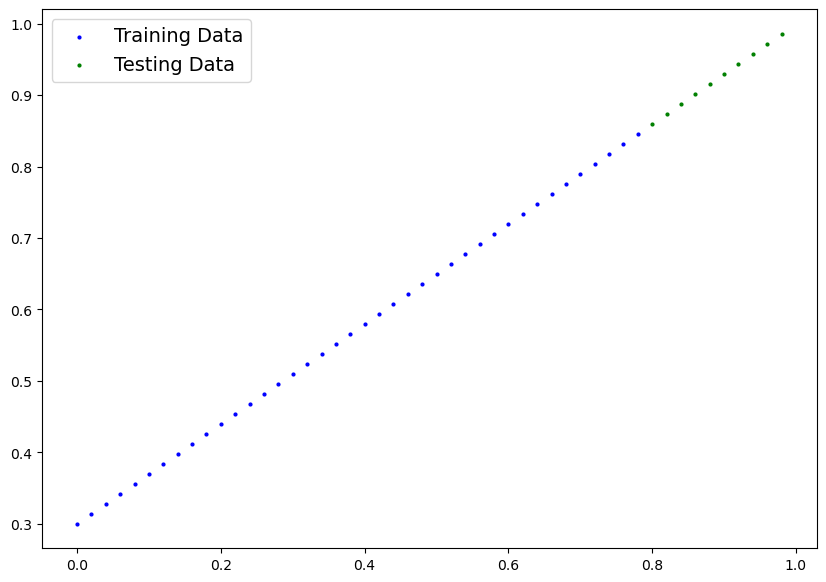

In [8]:
plot_predictions()

### 2. Build Model

Our First PyTorch Model!!

In [18]:
from torch import nn

# create linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )
        self.bias = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )

        
    # Forard method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [19]:
nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

Parameter containing:
tensor([0.0816], requires_grad=True)

`nn.Module` is the superclass, and when we do `LinearRegressionModule(nn.Module`, we create a subclass of nn.Module

When we subclass `nn.Module` we have to override `forward()` method - as this defines the forward computation of the model

`required_autograd = True` means PyTorch will keep track gradient of that particular parameter to be used with `torch.autograd` and gradient descent torch.nn modules.

`required_autograd` is `True` by default

#### PyTorch model Building Essentials
**Some of the most important PyTorch model building classes**

* `torch.nn` - contains all the building blocks for a computational graphs (a neural network is considered a computational graph)
* `torch.nn.Parameter` - what papameters should our model try and learn. Often a PyTorch layer from `torch.nn` will set these for us.
* `torch.nn.Module` - the base class for all neural network modules. If you subclass it, you should override `forward()` method
* `torch.optim` - this is where optimizers in PyTorch live. It helps with gradient descent
* `def forward()` - All the `nn.Module` subclasses require us to override forward(). This method defines what happens in the forward computation.

if we pass the data to our `LinearRegressionModel`, `forward()` will take that data and perform the computation defined inside `forward()`

**Help us load data**
* `torch.utils.data.Dataset`
* `torch.utils.data.DataLoader`

PyTorch is a big library.
Follow this [PyTorch CheatSeat](https://pytorch.org/tutorials/beginner/ptcheat.html) for more.

#### Checking out Internals of our PyTorch Model

Now we've created a model, let's see what's inside our model

So we can chek our model paraters or what's inside our model using `.parameters()`

In [153]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model
model_0 = LinearRegressionModel()

# check our the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [154]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Making Predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run it through the `forward()` method

In [155]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

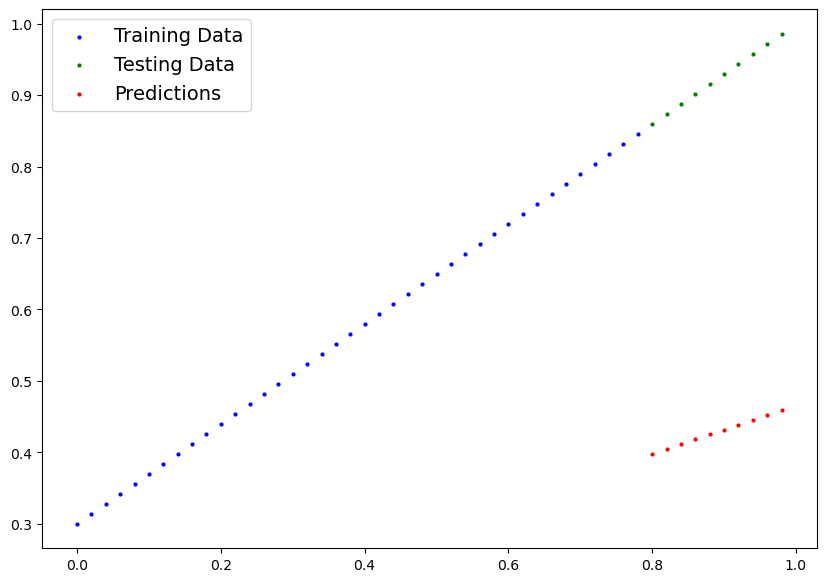

In [156]:
plot_predictions(predictions=y_preds)

Our `goal` is to move that `red dot` closer to the `green dots`

### 3. Train Model

The whole idea of training is for a model to move from some unknown parameters to some known parameters.

or in other words, `from` a `poor representation` of the data `to` a `better representation` of the data

One way to measure how poor or how wrong our models are is by calculating `loss function`

* Note: Loss function is also called `cost function` or `criterion` in different areas. For our case, we're going to refer to it as `loss function`

***Things we need for Training***:
* **Loss Function:** A function to measure how deviated our models prediction are from the ideal outputs. lower the deviation, better it it.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters(e.g. weights and biases)

**and specifically for `PyTorch`, we need**
* **A training loop**
* **A testing loop**
  

In [157]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [158]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Setting up a loss function and an optimizer

loss and optimizer comes in a same package cause they work together. 

Optimizers objective is to give parameters (w and b) values.

In [159]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

#### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
1. Loop through the data
2. Forward pass (this involves data moving though our model's `forward()` function) to make predictions on data - also called `forward propagation`
3. Calculate the loss (comprare forward pass predictions to ground truth lables)
4. Optimizer zero grad
5. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss. It is also called `Backpropagation`
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss - `Gradient Descent`

**Note**: `Gradient` is a slope.

In [160]:
torch.manual_seed(42)

# an epoch is one lopp through data... 
# this is a hyperparameter because we've set it ourselves
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 1. Loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # train model in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    print(f"loss: {loss}")
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagartion on the loss iwh respoct to the parameters of the model
    loss.backward()

    # 5. step the optimizer (perform gradient descent)
    optimizer.step() # by default the optimizer changes will accumulate through the loop so, we have to zero them above in step 3.

    ### Testing
    model_0.eval() # different settings in the model not needed for evaluation/testing purposes(dropout/batch norm layers)

    with torch.inference_mode(): # turn off gradient tracking and a couple of more things behind the scene
        # 1. do the forward pass
        test_pred = model_0(X_test)

        # 2. calculate the loss
        test_loss = loss_fn(test_pred, y_test)
        
    # print out what's happening
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print() 
        # print out model state_dict()
        print(model_0.state_dict())

loss: 0.31288138031959534
Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495

OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
loss: 0.3013603389263153
loss: 0.28983935713768005
loss: 0.2783183455467224
loss: 0.26679736375808716
loss: 0.2552763521671295
loss: 0.24375534057617188
loss: 0.23223432898521423
loss: 0.22071333229541779
loss: 0.20919232070446014
loss: 0.1976713240146637
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428

OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
loss: 0.18615034222602844
loss: 0.1746293306350708
loss: 0.16310831904411316
loss: 0.1515873372554779
loss: 0.14006635546684265
loss: 0.1285453587770462
loss: 0.11702437698841095
loss: 0.1060912236571312
loss: 0.09681284427642822
loss: 0.08908725529909134
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688

OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
loss: 0.08227583020925522
loss

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

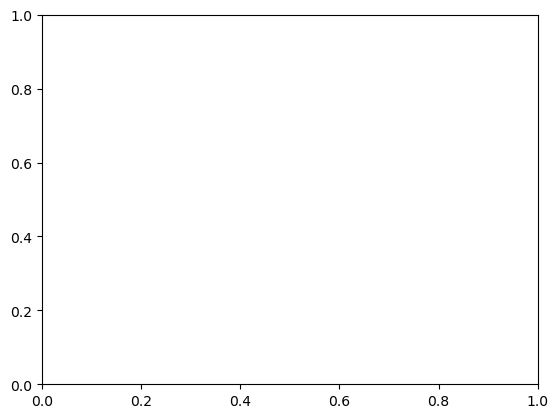

In [163]:
# plot the loss curves
plt.plot(epoch_count, loss_values, label="Train loss")


<div class='alert alert-danger'>
    We have an error here because, loss is in tensor and matplotlib works with numpy array.

    so we have to convert the tensor to numpy array
</div>

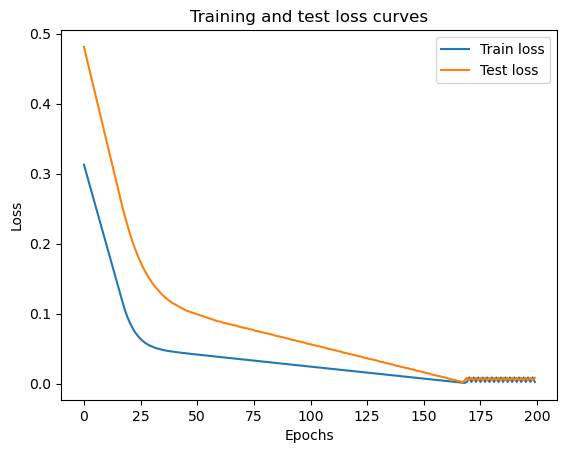

In [169]:
loss_values = torch.tensor(loss_values).numpy()

# plot the loss curves
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

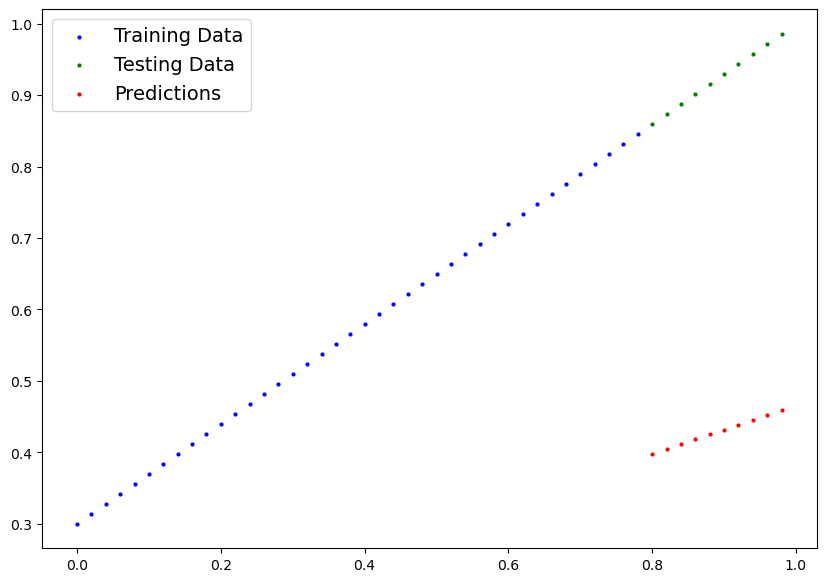

In [119]:
plot_predictions(predictions=y_preds)

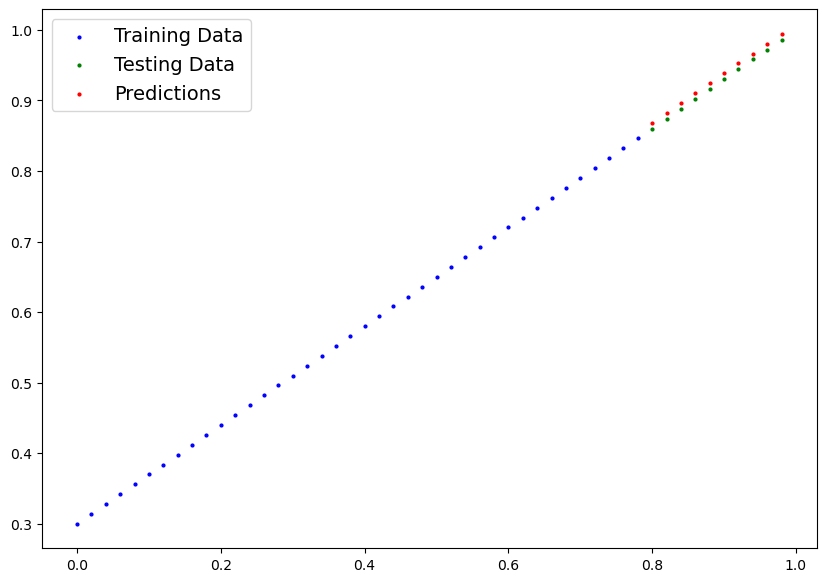

In [161]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new)

### 6. Saving and loading the model

There are `3` main methods you should know about for saving and loading models in PyTorch

1. `torch.save()` - allows you to save PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows us to load a model's saved state dictionary

#### 1. Saving the model

In [171]:
# saving a PyTorch Model

from pathlib import Path

# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # creates a folder `models` if it desn;t exist

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


#### 2. Loading a PyTorch Model

Since we saved our model's `state_dict()` rather than the entire model, we'll `create a new instance` of our `model class` and `pass` `stete_dict()`into that.


In [172]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [175]:
# To load a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.2345])), ('bias', tensor([0.2303]))])

`weights` and `bias` will be random when we instantiate

Now load the `saved_dict()` in the instantiated model

In [176]:
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [185]:
# make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [186]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [188]:
# comparate loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting it all together
Let's go back through the steps above and see it all in one place

In [14]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [15]:
# data
w = 0.7
b = 0.3

start = 0
end = 100
step = 0.02

X = torch.arange(start=start, end=end, step=step)

y = w*X + b

print(f"equation: y = {w}*X + {b}")

equation: y = 0.7*X + 0.3


In [16]:
# splitting the data
cutoff = int(len(X) * 0.8)

X_train = X[:cutoff]
X_test = X[cutoff:]

y_train = y[:cutoff]
y_test = y[cutoff:]

In [17]:
# building a model
torch.manual_seed(42)
class CustomLinearRegressionModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(
            torch.rand(1), requires_grad=True
        )
        self.bias = nn.Parameter(
            torch.rand(1), requires_grad=True
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight*x + self.bias

In [18]:
# torch.rand(1)

In [19]:
model_1 = CustomLinearRegressionModel()

list(model_1.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [20]:
model_1.state_dict()

OrderedDict([('weight', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [21]:
# making initial predictions
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([71.4965, 71.5142, 71.5318, 71.5495, 71.5671, 71.5848, 71.6024, 71.6201,
        71.6377, 71.6553, 71.6730, 71.6906, 71.7083, 71.7259, 71.7436, 71.7612,
        71.7789, 71.7965, 71.8142, 71.8318, 71.8494, 71.8671, 71.8847, 71.9024,
        71.9200, 71.9377, 71.9553, 71.9730, 71.9906, 72.0083, 72.0259, 72.0435,
        72.0612, 72.0788, 72.0965, 72.1141, 72.1318, 72.1494, 72.1671, 72.1847,
        72.2024, 72.2200, 72.2376, 72.2553, 72.2729, 72.2906, 72.3082, 72.3259,
        72.3435, 72.3612, 72.3788, 72.3965, 72.4141, 72.4317, 72.4494, 72.4670,
        72.4847, 72.5023, 72.5200, 72.5376, 72.5553, 72.5729, 72.5906, 72.6082,
        72.6258, 72.6435, 72.6611, 72.6788, 72.6964, 72.7141, 72.7317, 72.7494,
        72.7670, 72.7847, 72.8023, 72.8199, 72.8376, 72.8552, 72.8729, 72.8905,
        72.9082, 72.9258, 72.9435, 72.9611, 72.9788, 72.9964, 73.0140, 73.0317,
        73.0493, 73.0670, 73.0846, 73.1023, 73.1199, 73.1376, 73.1552, 73.1729,
        73.1905, 73.2081, 73.2258, 73.24

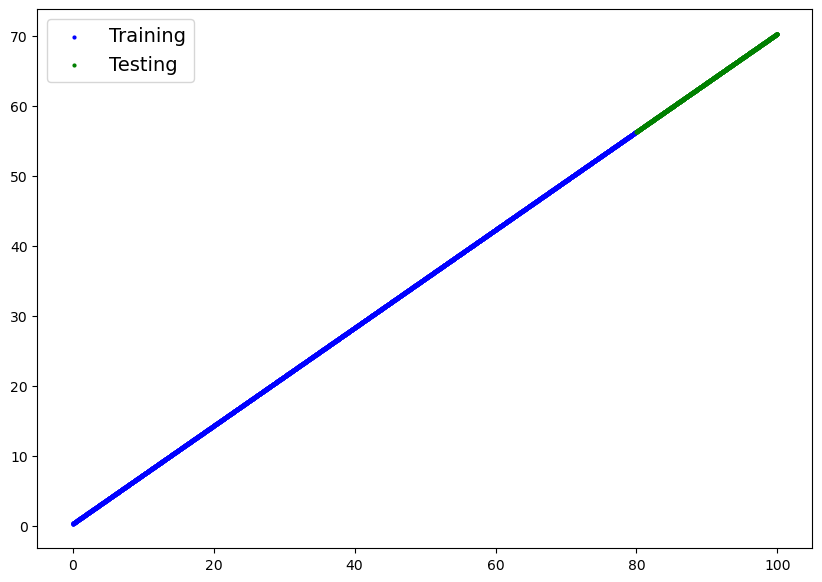

In [249]:
# plotting the graph

def plot_predictions(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, predictions=None):
    plt.figure(figsize=(10,7))
    
    plt.scatter(X_train, y_train, c='b', s=4, label="Training")
    plt.scatter(X_test, y_test, c='g', s=4, label="Testing")

    if predictions is not None:
        plt.scatter(X_test, predictions, c='r', s=4, label="Predictions")
    
    plt.legend(prop={"size":14});
    
plot_predictions()

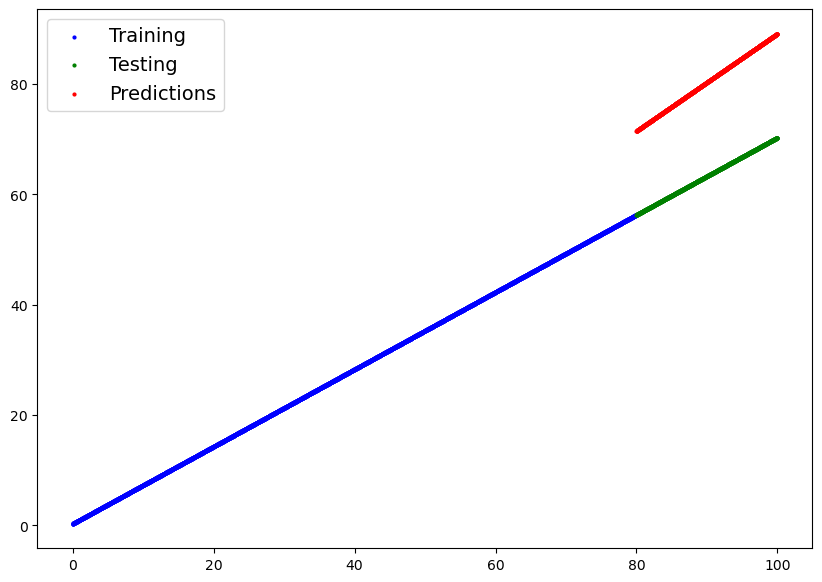

In [250]:
plot_predictions(predictions=y_preds)

In [251]:
from torch import nn

In [252]:
model_1.state_dict()

OrderedDict([('weight', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [274]:
# create/training a model

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)

epochs = 1000

for epoch in range(epochs):
    # Training Loop
    # set the model for training mode
    model_1.train()
    ## forward pass
    y_pred = model_1(X_train)

    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Tresting Loop
    #set the model for testing mode
    model_1.eval()
    with torch.inference_mode():
        ## forward pass
        test_preds = model_1(X_test)
        ## calculate the loss
        test_loss = loss_fn(test_preds, y_test)
        

model_1.state_dict()    

OrderedDict([('weight', tensor([0.7011])), ('bias', tensor([0.3151]))])

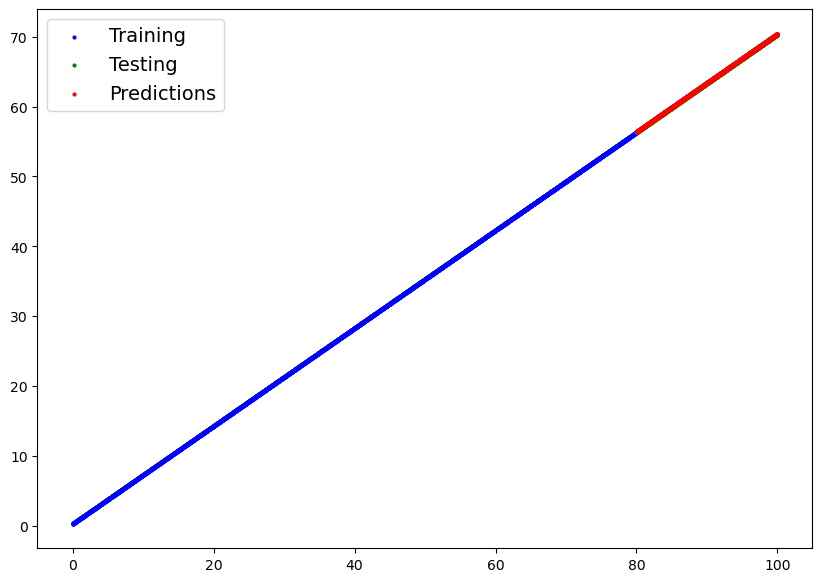

In [275]:
plot_predictions(predictions=test_preds)

In [25]:
## saving the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '01_pytorch_workflow_custom.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

In [34]:
## loading the model
## 1. create the instance of the model
## 2. load the state dict to the created instance of the model

loaded_model = CustomLinearRegressionModel()
state_dict = torch.load(f=MODEL_SAVE_PATH)

loaded_model.load_state_dict(state_dict)

## predicting using loaded model
loaded_model.eval()
with torch.inference_mode():
    loaded_y_preds = loaded_model(X_test)

# checking y_preds and loaded_y_preds
y_preds.sum() == loaded_y_preds.sum()

tensor(True)

#### Creating using nn.Linear()

In [36]:
class CusomLinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_layer = nn.Linear(
            in_features=1,
            out_features=1
        )
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


torch.manual_seed(42)
model_2 = CusomLinearRegressionModelV2()
model_2, model_2.state_dict()

(CusomLinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [39]:
next(model_2.parameters()).device

device(type='cpu')